# Day 1 — Build Dataset + EDA (Spotify Streaming History → Modeling Tables)

**Goal:** Create clean, enriched datasets from your personal Spotify streaming history (2012–2023) and generate a small set of story-ready EDA visuals.

**Outputs written by this notebook**
- `data/processed/listens_event_level.parquet` (one row per play)
- `data/processed/tracks_modeling_table.parquet` (one row per track; ready for Day 2)
- `data/processed/artists_modeling_table.parquet` (one row per artist; optional)
- `data/cache/audio_features.parquet` (Spotify track audio features + metadata cache)
- `data/cache/artist_genres.json` (Spotify artist genres cache)

**Expected runtime:** depends on how many unique tracks/artists you have and your Spotify API rate limits. Caching prevents repeated calls.

---

## Setup checklist
1. Create a Spotify Developer app and set `SPOTIPY_CLIENT_ID`, `SPOTIPY_CLIENT_SECRET`, `SPOTIPY_REDIRECT_URI` as environment variables.
2. Install deps: `pip install spotipy pandas numpy matplotlib plotly tqdm python-dotenv pyarrow`
3. (Optional) Add a CJK-capable font (Noto Sans CJK) to avoid tofu boxes in plots.


In [1]:
# Core imports
from __future__ import annotations

import json
import os
from pathlib import Path
from typing import Iterable, Dict, Any, List, Optional

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

# Optional: load .env in local dev
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)


In [2]:
# Paths (robust when notebook lives in notebooks/)
from pathlib import Path

HERE = Path().resolve()
PROJECT_DIR = HERE
# Walk upward until we find config.py (repo root marker)
while not (PROJECT_DIR / 'config.py').exists() and PROJECT_DIR != PROJECT_DIR.parent:
    PROJECT_DIR = PROJECT_DIR.parent

DATA_DIR = PROJECT_DIR / 'data'
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
CACHE_DIR = DATA_DIR / 'cache'
FIG_DIR = PROJECT_DIR / 'reports' / 'figures'

for d in [RAW_DIR, PROCESSED_DIR, CACHE_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Default location for Spotify JSON exports in this repo
DEFAULT_INPUT_DIR = RAW_DIR / 'spotify'
# Fallback for the ChatGPT sandbox environment
if not DEFAULT_INPUT_DIR.exists():
    DEFAULT_INPUT_DIR = Path('/mnt/data')

print('PROJECT_DIR:', PROJECT_DIR)
print('DEFAULT_INPUT_DIR:', DEFAULT_INPUT_DIR)
print('RAW_DIR:', RAW_DIR)
print('PROCESSED_DIR:', PROCESSED_DIR)
print('CACHE_DIR:', CACHE_DIR)
print('FIG_DIR:', FIG_DIR)


PROJECT_DIR: C:\Users\maxma\Documents\Spotify Project
DEFAULT_INPUT_DIR: C:\Users\maxma\Documents\Spotify Project\data\raw\spotify
RAW_DIR: C:\Users\maxma\Documents\Spotify Project\data\raw
PROCESSED_DIR: C:\Users\maxma\Documents\Spotify Project\data\processed
CACHE_DIR: C:\Users\maxma\Documents\Spotify Project\data\cache
FIG_DIR: C:\Users\maxma\Documents\Spotify Project\reports\figures


In [3]:
# CJK-safe plotting helper

def set_cjk_font(preferred_fonts: Optional[list[str]] = None) -> Optional[str]:
    # Attempt to set a CJK-capable font. Returns chosen font name (or None).
    if preferred_fonts is None:
        preferred_fonts = [
            'Noto Sans CJK JP',
            'Noto Sans CJK KR',
            'Noto Sans CJK SC',
            'Noto Sans JP',
            'Arial Unicode MS',
        ]

    available = {f.name for f in mpl.font_manager.fontManager.ttflist}
    for name in preferred_fonts:
        if name in available:
            mpl.rcParams['font.family'] = name
            mpl.rcParams['axes.unicode_minus'] = False
            return name

    # Fallback: DejaVu is commonly available but may not cover CJK fully
    mpl.rcParams['font.family'] = 'DejaVu Sans'
    mpl.rcParams['axes.unicode_minus'] = False
    return None

chosen = set_cjk_font()
print('CJK font chosen:' , chosen or '(fallback DejaVu Sans; install Noto Sans CJK for better coverage)')


CJK font chosen: (fallback DejaVu Sans; install Noto Sans CJK for better coverage)


## 1) Load + clean streaming history JSONs

We will:
- Read all `Streaming_History_Audio_*.json` files
- Keep only music tracks (exclude podcast episodes)
- Parse timestamps, build time features
- Keep raw playback facts: `ms_played`, `skipped`, start/end reasons


In [4]:
def load_streaming_history(input_dir: Path) -> pd.DataFrame:
    files = sorted(input_dir.glob('Streaming_History_Audio_*.json'))
    if not files:
        raise FileNotFoundError(f'No Streaming_History_Audio_*.json found in {input_dir}')

    dfs = []
    for fp in tqdm(files, desc='Reading streaming history JSON'):
        df = pd.read_json(fp)
        df['source_file'] = fp.name
        dfs.append(df)

    out = pd.concat(dfs, ignore_index=True)
    return out

raw_df = load_streaming_history(DEFAULT_INPUT_DIR)
raw_df.head(3)


Reading streaming history JSON:   0%|          | 0/9 [00:00<?, ?it/s]

,ts,username,platform,ms_played,conn_country,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,source_file
0,2012-08-31T17:21:11Z,1246157207,"iOS 5.1.1 (iPhone3,3)",21966,US,174.229.2.243,unknown,Kill Shit,Krizz Kaliko,Kickin' & Screamin',spotify:track:3eMfBkKz0ZuffMqIVHhNr1,NaN,NaN,NaN,,,False,True,False,0,False,Streaming_History_Audio_2012-2014_0.json
1,2012-08-31T17:30:20Z,1246157207,"iOS 5.1.1 (iPhone3,3)",454489,US,174.229.2.243,unknown,Mayday,Krizz Kaliko,Kickin' & Screamin',spotify:track:44eZ0RG3gWBfiD5o9pvIV9,NaN,NaN,NaN,,trackdone,False,False,False,0,False,Streaming_History_Audio_2012-2014_0.json
2,2012-08-31T17:31:17Z,1246157207,"iOS 5.1.1 (iPhone3,3)",59112,US,174.229.2.243,unknown,Dumb For You,Krizz Kaliko,Kickin' & Screamin',spotify:track:0uQWGMWQAtpISoXTEi5as6,NaN,NaN,NaN,trackdone,backbtn,False,True,False,0,False,Streaming_History_Audio_2012-2014_0.json


In [5]:
def clean_streaming_history(df: pd.DataFrame) -> pd.DataFrame:
    # Keep only music tracks (exclude podcast episodes)
    df = df.copy()

    # Standardize timestamp
    df['ts'] = pd.to_datetime(df['ts'], utc=True, errors='coerce')

    # Spotify exports sometimes include episodes; keep rows with track URIs
    df = df[df['spotify_track_uri'].notna()].copy()

    # Keep key identifiers
    df.rename(columns={
        'master_metadata_track_name': 'track_name',
        'master_metadata_album_artist_name': 'artist_name',
        'master_metadata_album_album_name': 'album_name',
    }, inplace=True)

    # Basic sanity
    df['ms_played'] = pd.to_numeric(df['ms_played'], errors='coerce')
    df = df[df['ms_played'].notna()].copy()
    df = df[df['ms_played'] > 0].copy()

    # Time features
    df['date'] = df['ts'].dt.date
    df['year'] = df['ts'].dt.year
    df['month'] = df['ts'].dt.month
    df['year_month'] = df['ts'].dt.to_period('M').astype(str)
    df['dayofweek'] = df['ts'].dt.dayofweek
    df['hour'] = df['ts'].dt.hour

    # Playback features
    df['seconds_played'] = df['ms_played'] / 1000.0

    # Ensure boolean-ish skipped field
    if 'skipped' in df.columns:
        df['skipped'] = df['skipped'].fillna(False).astype(bool)
    else:
        df['skipped'] = False

    # Minimal columns for event-level modeling
    keep = [
        'ts','date','year','month','year_month','dayofweek','hour',
        'track_name','artist_name','album_name','spotify_track_uri',
        'ms_played','seconds_played','skipped',
        'reason_start','reason_end','shuffle','platform','conn_country','source_file'
    ]
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    return df

df = clean_streaming_history(raw_df)
print('rows:', len(df))
print('unique tracks:', df['spotify_track_uri'].nunique())
print('unique artists:', df['artist_name'].nunique())
df.head(3)


C:\Users\maxma\AppData\Local\Temp\ipykernel_45556\3514461304.py:27: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['ts'].dt.to_period('M').astype(str)


rows: 136946
unique tracks: 25516
unique artists: 6144


,ts,date,year,month,year_month,dayofweek,hour,track_name,artist_name,album_name,spotify_track_uri,ms_played,seconds_played,skipped,reason_start,reason_end,shuffle,platform,conn_country,source_file
0,2012-08-31 17:21:11+00:00,2012-08-31,2012,8,2012-08,4,17,Kill Shit,Krizz Kaliko,Kickin' & Screamin',spotify:track:3eMfBkKz0ZuffMqIVHhNr1,21966,21.966,True,,,False,"iOS 5.1.1 (iPhone3,3)",US,Streaming_History_Audio_2012-2014_0.json
1,2012-08-31 17:30:20+00:00,2012-08-31,2012,8,2012-08,4,17,Mayday,Krizz Kaliko,Kickin' & Screamin',spotify:track:44eZ0RG3gWBfiD5o9pvIV9,454489,454.489,False,,trackdone,False,"iOS 5.1.1 (iPhone3,3)",US,Streaming_History_Audio_2012-2014_0.json
2,2012-08-31 17:31:17+00:00,2012-08-31,2012,8,2012-08,4,17,Dumb For You,Krizz Kaliko,Kickin' & Screamin',spotify:track:0uQWGMWQAtpISoXTEi5as6,59112,59.112,True,trackdone,backbtn,False,"iOS 5.1.1 (iPhone3,3)",US,Streaming_History_Audio_2012-2014_0.json


## 2) Spotify API enrichment (cached)

We will add:
- Track metadata: `track_id`, `track_popularity`, `duration_ms`, `explicit`, `album_release_date`
- Audio features: danceability, energy, valence, tempo, etc.

We cache results to `data/cache/audio_features.parquet`.


In [6]:
# Spotify API setup (Day 1: metadata/genres). Audio features may be blocked (403).

import importlib.util
from pathlib import Path

# Load config.py from repo root (avoids importing a wrong module named `config`)
HERE = Path().resolve()
ROOT_DIR = HERE
while not (ROOT_DIR / 'config.py').exists() and ROOT_DIR != ROOT_DIR.parent:
    ROOT_DIR = ROOT_DIR.parent

config_path = ROOT_DIR / 'config.py'
spec = importlib.util.spec_from_file_location('config', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id=config.spotify['client_id'],
        client_secret=config.spotify['client_secret'],
    )
)

# Quick ping
res = sp.search(q='test', limit=1)
print('Spotify API OK. Sample track:', res['tracks']['items'][0]['name'])


Spotify API OK. Sample track: Test & Recognise (Flume Re-work)


In [7]:
AUDIO_CACHE_FP = CACHE_DIR / 'audio_features.parquet'

def uri_to_id(uri: str) -> str:
    # spotify:track:<id>
    return uri.split(':')[-1]

from spotipy.exceptions import SpotifyException

AUDIO_FEATURE_KEYS = [
    'danceability','energy','key','loudness','mode','speechiness','acousticness',
    'instrumentalness','liveness','valence','tempo','time_signature'
]

def fetch_track_metadata_and_audio_features(track_uris, batch_size: int = 50) -> pd.DataFrame:
    # Fetch track metadata for URIs; attempt audio features, but continue if blocked (403).
    track_uris = list(track_uris)
    track_ids = [uri_to_id(u) for u in track_uris]

    rows = []
    audio_features_available = True

    for i in tqdm(range(0, len(track_ids), batch_size), desc='Spotify tracks()'):
        batch_ids = track_ids[i:i+batch_size]
        batch_uris = track_uris[i:i+batch_size]

        tracks_resp = sp.tracks(batch_ids)
        tracks = tracks_resp.get('tracks', [])

        feats_by_id = {}
        if audio_features_available:
            try:
                feats = sp.audio_features(batch_ids)
                feats_by_id = {f['id']: f for f in feats if f and f.get('id')}
            except SpotifyException as e:
                if getattr(e, 'http_status', None) == 403:
                    audio_features_available = False
                    print(
    "\n⚠️ Spotify /audio-features endpoint blocked (403). "
    "Continuing WITHOUT audio features.\n"
)
                else:
                    raise

        for uri, t in zip(batch_uris, tracks):
            if not t:
                continue
            tid = t.get('id')
            album = t.get('album') or {}
            artists = t.get('artists') or [{}]

            row = {
                'spotify_track_uri': uri,
                'track_id': tid,
                'track_popularity': t.get('popularity'),
                'duration_ms': t.get('duration_ms'),
                'explicit': t.get('explicit'),
                'album_release_date': album.get('release_date'),
                'album_release_date_precision': album.get('release_date_precision'),
                'artist_id_primary': artists[0].get('id'),
                'artist_name_primary': artists[0].get('name'),
            }

            af = feats_by_id.get(tid)
            if af:
                for k in AUDIO_FEATURE_KEYS:
                    row[k] = af.get(k)

            rows.append(row)

    return pd.DataFrame(rows)

# Build/refresh cache
unique_uris = sorted(df['spotify_track_uri'].dropna().unique().tolist())

if AUDIO_CACHE_FP.exists():
    audio_cache = pd.read_parquet(AUDIO_CACHE_FP)
    cached_uris = set(audio_cache['spotify_track_uri'].unique())
    missing_uris = [u for u in unique_uris if u not in cached_uris]
    print(f'Audio cache found: {len(cached_uris)} cached, {len(missing_uris)} missing')
else:
    audio_cache = pd.DataFrame()
    missing_uris = unique_uris
    print('No audio cache found; fetching all tracks...')

if missing_uris:
    fetched = fetch_track_metadata_and_audio_features(missing_uris)
    print('Fetched rows:', len(fetched))
    audio_cache = pd.concat([audio_cache, fetched], ignore_index=True)
    audio_cache = audio_cache.drop_duplicates(subset=['spotify_track_uri'], keep='last')
    audio_cache.to_parquet(AUDIO_CACHE_FP, index=False)
    print('Wrote:', AUDIO_CACHE_FP)

print('audio_cache rows:', len(audio_cache))
audio_cache.head(3)


Audio cache found: 25516 cached, 0 missing
audio_cache rows: 25516


,spotify_track_uri,track_id,track_popularity,duration_ms,explicit,album_release_date,album_release_date_precision,artist_id_primary,artist_name_primary
0,spotify:track:002AzLaJtX4Tyi7Yv0J49w,002AzLaJtX4Tyi7Yv0J49w,0,210378,False,2020-08-11,day,5a8EJtOEbUJDF4RX3mKK02,Woo
1,spotify:track:003FTlCpBTM4eSqYSWPv4H,003FTlCpBTM4eSqYSWPv4H,70,233266,False,2002-10-15,day,3vAaWhdBR38Q02ohXqaNHT,The All-American Rejects
2,spotify:track:003vvx7Niy0yvhvHt4a68B,003vvx7Niy0yvhvHt4a68B,91,222973,False,2004,year,0C0XlULifJtAgn6ZNCW2eu,The Killers


In [8]:
# Merge enrichment into event-level df

df_enriched = df.merge(audio_cache, on='spotify_track_uri', how='left')

# Listen ratio (more defensible than a fixed 30-second rule)
# Note: duration_ms can be missing for some tracks; handle safely

df_enriched['listen_ratio'] = df_enriched['ms_played'] / df_enriched['duration_ms']
df_enriched['listen_ratio'] = df_enriched['listen_ratio'].replace([np.inf, -np.inf], np.nan)
# Clip extreme ratios (some exports can exceed duration slightly)
df_enriched['listen_ratio'] = df_enriched['listen_ratio'].clip(lower=0, upper=1.5)

# Buckets for narrative + modeling
bins = [-0.01, 0.2, 0.8, 1.5]
labels = ['skip_early', 'partial', 'complete']
df_enriched['listen_bucket'] = pd.cut(df_enriched['listen_ratio'], bins=bins, labels=labels)

print(df_enriched[['seconds_played','duration_ms','listen_ratio','listen_bucket']].head(10))


# Overwrite df with enriched version to avoid confusion in later cells
df = df_enriched


   seconds_played  duration_ms  listen_ratio listen_bucket
0          21.966       240106      0.091485    skip_early
1         454.489       261453      1.500000      complete
2          59.112       150693      0.392268       partial
3         261.453       261453      1.000000      complete
4          22.923       150693      0.152117    skip_early
5          35.387       261453      0.135347    skip_early
6         160.172       248440      0.644711       partial
7         209.413       209413      1.000000      complete
8          11.331       256653      0.044149    skip_early
9           2.368       203280      0.011649    skip_early


## 3) Artist genres (cached)

Spotify genres are usually at the **artist** level. We'll:
- collect primary artist IDs from track metadata
- call `artists()` in batches
- cache to `data/cache/artist_genres.json`


In [9]:
GENRE_CACHE_FP = CACHE_DIR / 'artist_genres.json'

def fetch_artist_genres(artist_ids: list[str], batch_size: int = 50) -> dict[str, list[str]]:
    out: dict[str, list[str]] = {}
    artist_ids = [a for a in artist_ids if isinstance(a, str) and a]

    for i in tqdm(range(0, len(artist_ids), batch_size), desc='Spotify artists()'):
        batch = artist_ids[i:i+batch_size]
        resp = sp.artists(batch)
        for a in resp.get('artists', []) or []:
            if not a:
                continue
            out[a.get('id')] = a.get('genres') or []

    return out

# Load cache if exists
if GENRE_CACHE_FP.exists():
    artist_genres = json.load(open(GENRE_CACHE_FP, 'r', encoding='utf-8'))
else:
    artist_genres = {}

artist_ids = sorted(set(df_enriched['artist_id_primary'].dropna().astype(str)))
missing_ids = [a for a in artist_ids if a not in artist_genres]
print('artists total:', len(artist_ids), 'missing:', len(missing_ids))

if missing_ids:
    new_map = fetch_artist_genres(missing_ids)
    artist_genres.update(new_map)
    with open(GENRE_CACHE_FP, 'w', encoding='utf-8') as f:
        json.dump(artist_genres, f, ensure_ascii=False, indent=2)
    print('Wrote:', GENRE_CACHE_FP)

# Add genres to enriched df

def primary_genre(genres: list[str]) -> str:
    if not genres:
        return 'unknown'
    return genres[0]

df_enriched['artist_genres'] = df_enriched['artist_id_primary'].map(artist_genres)
df_enriched['artist_genres'] = df_enriched['artist_genres'].apply(lambda x: x if isinstance(x, list) else [])
df_enriched['primary_genre'] = df_enriched['artist_genres'].apply(primary_genre)

df_enriched[['artist_name','artist_name_primary','primary_genre']].head(10)


artists total: 6174 missing: 0


,artist_name,artist_name_primary,primary_genre
0,Krizz Kaliko,Krizz Kaliko,country hip hop
1,Krizz Kaliko,Krizz Kaliko,country hip hop
2,Krizz Kaliko,Krizz Kaliko,country hip hop
3,Krizz Kaliko,Krizz Kaliko,country hip hop
4,Krizz Kaliko,Krizz Kaliko,country hip hop
5,Krizz Kaliko,Krizz Kaliko,country hip hop
6,Queen,Queen,classic rock
7,Queen,Queen,classic rock
8,Queen,Queen,classic rock
9,Queen,Queen,classic rock


## 4) Build modeling tables

### Event-level table
One row per play (keeps context like hour, platform, reason_end).

### Track-level table (Day 2 ready)
One row per track with aggregated behavior + content features.


In [10]:
# Event-level exports
EVENT_FP = PROCESSED_DIR / 'listens_event_level.parquet'

# Keep an explicit ordered set of columns
event_cols = [
    'ts','date','year','month','year_month','dayofweek','hour',
    'spotify_track_uri','track_id','track_name','artist_name','artist_id_primary','artist_name_primary','album_name',
    'ms_played','seconds_played','duration_ms','listen_ratio','listen_bucket','skipped',
    'primary_genre','artist_genres',
    'danceability','energy','valence','tempo','acousticness','instrumentalness','liveness','speechiness','loudness','mode','key','time_signature',
    'track_popularity','album_release_date',
    'reason_start','reason_end','shuffle','platform','conn_country','source_file'
]
event_cols = [c for c in event_cols if c in df_enriched.columns]

listens_event = df_enriched[event_cols].copy()
listens_event.to_parquet(EVENT_FP, index=False)
print('Wrote:', EVENT_FP)
listens_event.head(3)


Wrote: C:\Users\maxma\Documents\Spotify Project\data\processed\listens_event_level.parquet


,ts,date,year,month,year_month,dayofweek,hour,spotify_track_uri,track_id,track_name,artist_name,artist_id_primary,artist_name_primary,album_name,ms_played,seconds_played,duration_ms,listen_ratio,listen_bucket,skipped,primary_genre,artist_genres,track_popularity,album_release_date,reason_start,reason_end,shuffle,platform,conn_country,source_file
0,2012-08-31 17:21:11+00:00,2012-08-31,2012,8,2012-08,4,17,spotify:track:3eMfBkKz0ZuffMqIVHhNr1,3eMfBkKz0ZuffMqIVHhNr1,Kill Shit,Krizz Kaliko,3SEJQy90Vgg1aSnZ9b4AU9,Krizz Kaliko,Kickin' & Screamin',21966,21.966,240106,0.091485,skip_early,True,country hip hop,[country hip hop],0,2012-05-15,,,False,"iOS 5.1.1 (iPhone3,3)",US,Streaming_History_Audio_2012-2014_0.json
1,2012-08-31 17:30:20+00:00,2012-08-31,2012,8,2012-08,4,17,spotify:track:44eZ0RG3gWBfiD5o9pvIV9,44eZ0RG3gWBfiD5o9pvIV9,Mayday,Krizz Kaliko,3SEJQy90Vgg1aSnZ9b4AU9,Krizz Kaliko,Kickin' & Screamin',454489,454.489,261453,1.500000,complete,False,country hip hop,[country hip hop],0,2012-05-15,,trackdone,False,"iOS 5.1.1 (iPhone3,3)",US,Streaming_History_Audio_2012-2014_0.json
2,2012-08-31 17:31:17+00:00,2012-08-31,2012,8,2012-08,4,17,spotify:track:0uQWGMWQAtpISoXTEi5as6,0uQWGMWQAtpISoXTEi5as6,Dumb For You,Krizz Kaliko,3SEJQy90Vgg1aSnZ9b4AU9,Krizz Kaliko,Kickin' & Screamin',59112,59.112,150693,0.392268,partial,True,country hip hop,[country hip hop],0,2012-05-15,trackdone,backbtn,False,"iOS 5.1.1 (iPhone3,3)",US,Streaming_History_Audio_2012-2014_0.json


In [11]:
# Track-level modeling table
TRACK_FP = PROCESSED_DIR / 'tracks_modeling_table.parquet'

agg = {
    'ts': ['min','max'],
    'ms_played': ['count','sum','mean'],
    'listen_ratio': ['mean','median'],
    'skipped': ['mean'],
    'seconds_played': ['mean','median'],
    'duration_ms': ['first'],
}

track_df = df_enriched.groupby('spotify_track_uri').agg(agg)
track_df.columns = ['_'.join([c for c in col if c]) for col in track_df.columns.values]
track_df = track_df.reset_index()

# Rename for clarity
track_df = track_df.rename(columns={
    'ms_played_count': 'play_count',
    'ms_played_sum': 'total_ms_played',
    'ms_played_mean': 'avg_ms_played',
    'skipped_mean': 'skip_rate',
    'ts_min': 'first_played_ts',
    'ts_max': 'last_played_ts',
    'listen_ratio_mean': 'avg_listen_ratio',
    'listen_ratio_median': 'median_listen_ratio',
    'seconds_played_mean': 'avg_seconds_played',
    'seconds_played_median': 'median_seconds_played',
    'duration_ms_first': 'duration_ms'
})

# Join static metadata/audio features WITHOUT column collisions
# - track_df already has a stable duration_ms from aggregation
# - audio_cache also has duration_ms; we rename it to duration_ms_spotify then coalesce
meta_cols = [
    'spotify_track_uri','track_id','artist_id_primary','artist_name_primary',
    'track_popularity','explicit','album_release_date','album_release_date_precision',
    'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature',
    'duration_ms'  # keep temporarily so we can coalesce
]
meta_cols = [c for c in meta_cols if c in audio_cache.columns]
track_meta = audio_cache[meta_cols].drop_duplicates(subset=['spotify_track_uri']).copy()

if 'duration_ms' in track_meta.columns:
    track_meta = track_meta.rename(columns={'duration_ms': 'duration_ms_spotify'})

track_df = track_df.merge(track_meta, on='spotify_track_uri', how='left', validate='1:1')

# Coalesce duration_ms and drop the renamed helper
if 'duration_ms_spotify' in track_df.columns:
    track_df['duration_ms'] = track_df['duration_ms'].fillna(track_df['duration_ms_spotify'])
    track_df = track_df.drop(columns=['duration_ms_spotify'])

# Defensive: drop any accidental suffix columns
suffix_cols = [c for c in track_df.columns if c.endswith('_x') or c.endswith('_y')]
if suffix_cols:
    print('Dropping unexpected suffix columns:', suffix_cols)
    track_df = track_df.drop(columns=suffix_cols, errors='ignore')

# Add a representative name/album from event df (most common)
name_df = (df_enriched.groupby('spotify_track_uri')
           .agg(track_name=('track_name', lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]),
                artist_name=('artist_name', lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]),
                album_name=('album_name', lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]),
                primary_genre=('primary_genre', lambda s: s.mode().iloc[0] if not s.mode().empty else 'unknown'))
           .reset_index())

track_df = track_df.merge(name_df, on='spotify_track_uri', how='left')

# Simple recency (days since last play) for Day 2 ranking
now = pd.Timestamp.utcnow()
track_df['days_since_last_play'] = (now - pd.to_datetime(track_df['last_played_ts'], utc=True)).dt.total_seconds() / (3600*24)

# Save
track_df.to_parquet(TRACK_FP, index=False)
print('Wrote:', TRACK_FP)
track_df.sort_values('play_count', ascending=False).head(10)


Wrote: C:\Users\maxma\Documents\Spotify Project\data\processed\tracks_modeling_table.parquet


,spotify_track_uri,first_played_ts,last_played_ts,play_count,total_ms_played,avg_ms_played,avg_listen_ratio,median_listen_ratio,skip_rate,avg_seconds_played,median_seconds_played,duration_ms,track_id,artist_id_primary,artist_name_primary,track_popularity,explicit,album_release_date,album_release_date_precision,track_name,artist_name,album_name,primary_genre,days_since_last_play
14903,spotify:track:4X8VB7lmL7o4QiypDYmqaA,2020-11-18 19:25:21+00:00,2023-07-26 20:03:07+00:00,194,35560943,183303.829897,0.850787,1.0,0.067010,183.303830,215.452,215452,4X8VB7lmL7o4QiypDYmqaA,0nq64XZMWV1s7XHXIkdH7K,The Wonder Years,54,True,2013-05-14,day,Passing Through A Screen Door,The Wonder Years,The Greatest Generation,pop punk,905.011015
15731,spotify:track:4mVzCmTZeBOkvSQsuvFQWh,2020-11-19 14:21:35+00:00,2023-07-28 15:00:00+00:00,193,35560780,184252.746114,0.752839,1.0,0.072539,184.252746,244.744,244744,4mVzCmTZeBOkvSQsuvFQWh,0nq64XZMWV1s7XHXIkdH7K,The Wonder Years,56,False,2011-06-14,day,Came Out Swinging,The Wonder Years,Suburbia I've Given You All and Now I'm Nothing,pop punk,903.221512
14923,spotify:track:4XTJFHSPamFmR6Xs6rM0kD,2014-11-11 09:25:11+00:00,2017-04-02 20:04:37+00:00,140,27175136,194108.114286,0.832178,1.0,0.185714,194.108114,233.253,233253,4XTJFHSPamFmR6Xs6rM0kD,1OKOTYGoCE2buxTYMegJp7,Streetlight Manifesto,0,False,2007,year,Forty Days,Streetlight Manifesto,Somewhere In The Between,ska,3211.009973
8060,spotify:track:2SSFvQBwsxeazzo7z5l9gD,2014-12-25 06:32:35+00:00,2019-11-22 18:34:13+00:00,137,24483433,178711.189781,0.799914,1.0,0.189781,178.711190,223.413,223413,2SSFvQBwsxeazzo7z5l9gD,77AiFEVeAVj2ORpC85QVJs,Steve Aoki,59,False,2014-09-29,day,Delirious (Boneless) (feat. Kid Ink),Steve Aoki,Neon Future I,electro house,2247.072751
19801,spotify:track:64BvArPNcub2hM9m90lRFw,2014-11-10 20:18:08+00:00,2017-04-01 18:42:10+00:00,136,22698387,166899.904412,0.827548,1.0,0.169118,166.899904,201.680,201680,64BvArPNcub2hM9m90lRFw,1OKOTYGoCE2buxTYMegJp7,Streetlight Manifesto,0,False,2007,year,Would You Be Impressed,Streetlight Manifesto,Somewhere In The Between,ska,3212.067230
3546,spotify:track:15FlkvOEu8iFCBPZ64heHJ,2014-12-25 06:31:03+00:00,2019-10-05 12:38:37+00:00,136,31352045,230529.742647,0.808349,1.0,0.198529,230.529743,285.186,285186,15FlkvOEu8iFCBPZ64heHJ,77AiFEVeAVj2ORpC85QVJs,Steve Aoki,41,True,2014-09-29,day,Rage the Night Away (feat. Waka Flocka Flame),Steve Aoki,Neon Future I,electro house,2295.319695
6714,spotify:track:22bdXU26ewL0ji9K9acT5J,2020-06-22 21:37:36+00:00,2022-06-17 00:51:35+00:00,133,19073931,143413.015038,0.877101,1.0,0.000000,143.413015,163.508,163508,22bdXU26ewL0ji9K9acT5J,1lKZzN2d4IqiEYxyECIEHI,Hot Mulligan,0,False,2018-03-23,day,How Do You Know It’s Not Armadillo Shells?,Hot Mulligan,Pilot,midwest emo,1309.810691
20626,spotify:track:6J7cSyvSCnPwv3vqHchEfL,2013-07-19 04:52:19+00:00,2020-09-30 19:00:11+00:00,133,22914103,172286.488722,0.708339,1.0,0.225564,172.286489,243.226,243226,6J7cSyvSCnPwv3vqHchEfL,4NiJW4q9ichVqL1aUsgGAN,A Day To Remember,0,False,2009,year,If It Means a Lot to You,A Day To Remember,Homesick,metalcore,1934.054718
5633,spotify:track:1iD0a0plhO55cWEJa5UGcZ,2014-11-19 19:50:31+00:00,2022-07-24 18:25:46+00:00,126,18052189,143271.341270,0.769176,1.0,0.190476,143.271341,186.266,186266,1iD0a0plhO55cWEJa5UGcZ,20oQv3LStCKCjI9oQ0JNha,Less Than Jake,56,False,2003-05-19,day,The Science of Selling Yourself Short,Less Than Jake,Anthem,ska punk,1272.078619
12164,spotify:track:3imITUqEhkebNbOoS1yrWm,2013-07-08 11:07:23+00:00,2020-10-01 05:33:17+00:00,126,19439746,154283.698413,0.761368,1.0,0.126984,154.283698,202.640,202640,3imITUqEhkebNbOoS1yrWm,4NiJW4q9ichVqL1aUsgGAN,A Day To Remember,1,False,2010,year,All I Want,A Day To Remember,What Separates Me From You,metalcore,1933.615066


## 5) EDA: minimum set of story-ready visuals

We will generate four visuals that are strong “blog/dashboard starters”:
1. Listening volume over time (monthly)
2. Top artists by play count
3. Listen ratio distribution
4. Genre share over time (top genres)

All plots should display CJK titles safely.


Saved: C:\Users\maxma\Documents\Spotify Project\reports\figures\01_listening_volume_monthly.png


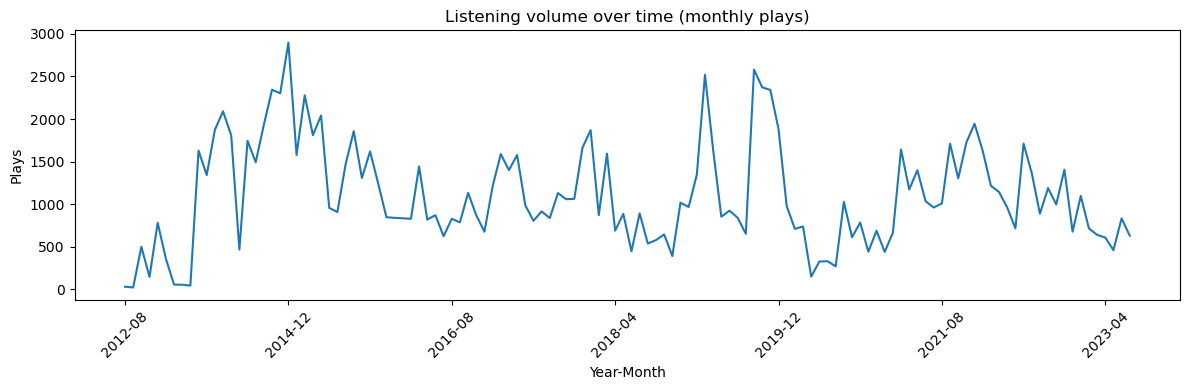

In [12]:
# 1) Listening volume over time
plt.figure(figsize=(12,4))
monthly = listens_event.groupby('year_month').size().sort_index()
monthly.plot()
plt.title('Listening volume over time (monthly plays)')
plt.xlabel('Year-Month')
plt.ylabel('Plays')
plt.xticks(rotation=45)
plt.tight_layout()
fp = FIG_DIR / '01_listening_volume_monthly.png'
plt.savefig(fp, dpi=200)
print('Saved:', fp)
plt.show()


Saved: C:\Users\maxma\Documents\Spotify Project\reports\figures\02_top_artists.png


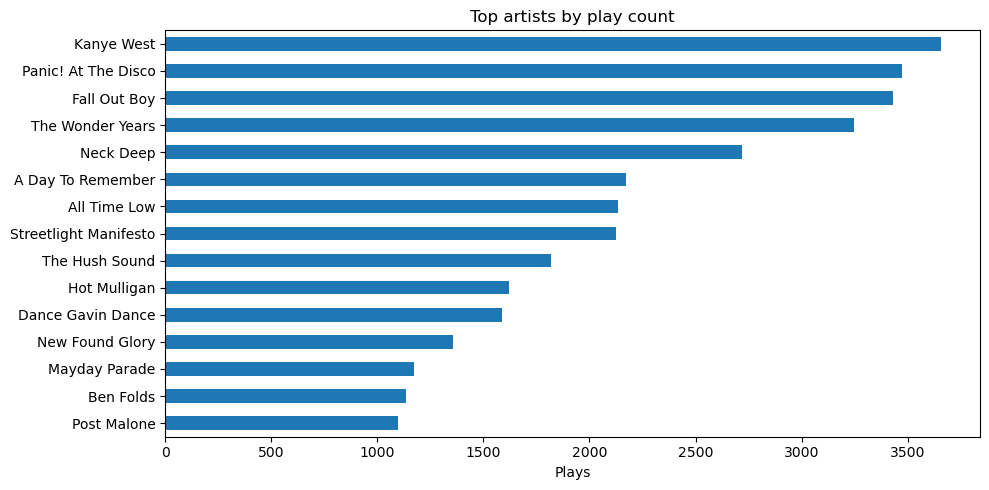

In [13]:
# 2) Top artists by play count
plt.figure(figsize=(10,5))
top_artists = listens_event['artist_name'].value_counts().head(15)[::-1]
top_artists.plot(kind='barh')
plt.title('Top artists by play count')
plt.xlabel('Plays')
plt.tight_layout()
fp = FIG_DIR / '02_top_artists.png'
plt.savefig(fp, dpi=200)
print('Saved:', fp)
plt.show()


Saved: C:\Users\maxma\Documents\Spotify Project\reports\figures\03_listen_ratio_distribution.png


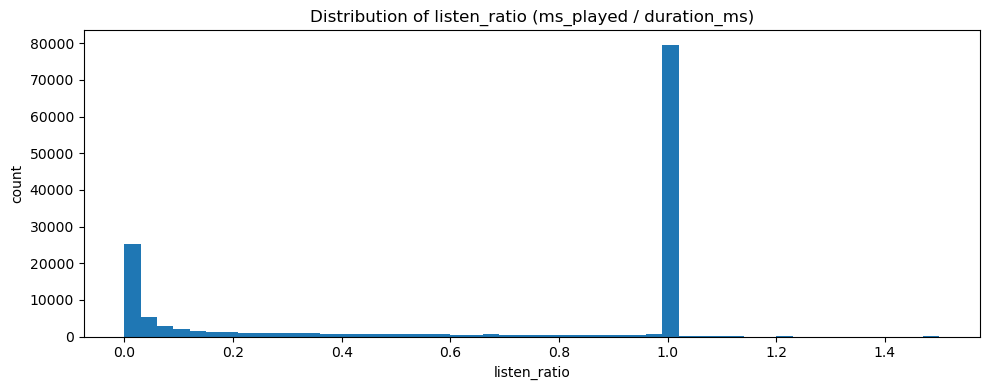

complete      83825
skip_early    38917
partial       14196
NaN               8
Name: listen_bucket, dtype: int64


In [14]:
# 3) Listen ratio distribution
plt.figure(figsize=(10,4))
vals = listens_event['listen_ratio'].dropna()
plt.hist(vals, bins=50)
plt.title('Distribution of listen_ratio (ms_played / duration_ms)')
plt.xlabel('listen_ratio')
plt.ylabel('count')
plt.tight_layout()
fp = FIG_DIR / '03_listen_ratio_distribution.png'
plt.savefig(fp, dpi=200)
print('Saved:', fp)
plt.show()

print(listens_event['listen_bucket'].value_counts(dropna=False))


Saved: C:\Users\maxma\Documents\Spotify Project\reports\figures\04_genre_share_over_time.png


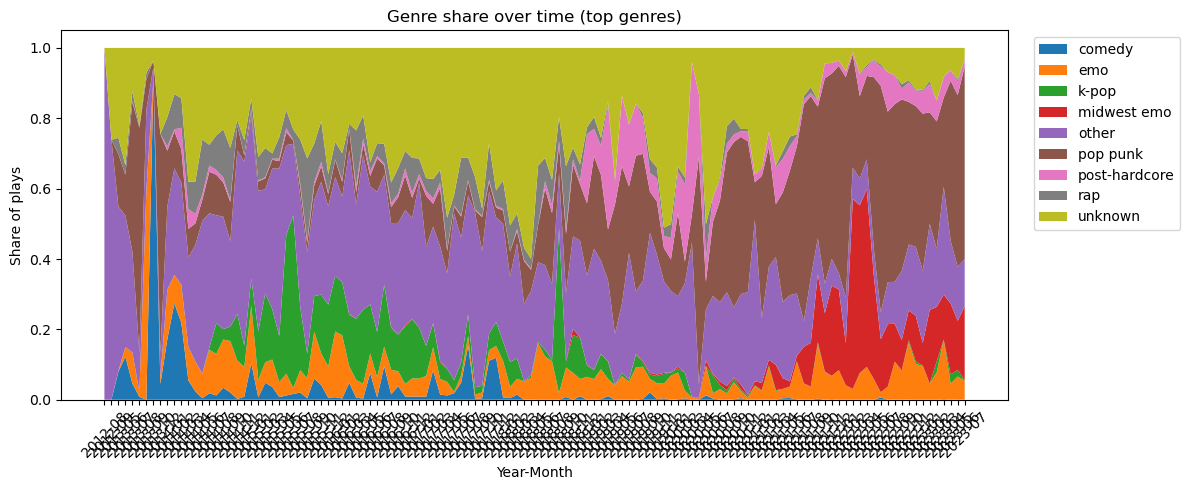

In [15]:
# 4) Genre share over time (top 8 genres by volume)

# Prepare top genres
counts = listens_event['primary_genre'].value_counts()
top_genres = counts.head(8).index.tolist()

d = listens_event.copy()
d['genre_for_plot'] = d['primary_genre'].where(d['primary_genre'].isin(top_genres), other='other')

pivot = (d.pivot_table(index='year_month', columns='genre_for_plot', values='spotify_track_uri', aggfunc='count')
         .fillna(0)
         .sort_index())

share = pivot.div(pivot.sum(axis=1), axis=0)

plt.figure(figsize=(12,5))
plt.stackplot(share.index, share.T.values, labels=share.columns)
plt.title('Genre share over time (top genres)')
plt.xlabel('Year-Month')
plt.ylabel('Share of plays')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()
fp = FIG_DIR / '04_genre_share_over_time.png'
plt.savefig(fp, dpi=200)
print('Saved:', fp)
plt.show()


## Day 1 ✅ Exit criteria

If you got this far, Day 1 is complete:
- You have **event-level** and **track-level** modeling tables written to disk
- You have **audio features + genres cached**
- You generated 4 story-ready visuals

Next: Day 2 will build a recommender using the track table (content similarity / TFRS) and evaluate recommendation quality.
